In [1]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from __future__ import (absolute_import, division, print_function,             
                        unicode_literals)                                      
import pickle
import os
import random

from surprise import Dataset 
from surprise.model_selection import cross_validate
from surprise import Reader
from surprise import SVD
from surprise import NMF
from surprise import KNNBasic
from surprise import CoClustering
from surprise import SVDpp
from surprise import SlopeOne
from surprise import dump
from surprise.accuracy import rmse
from surprise.model_selection import KFold
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy
from collections import defaultdict

import io  
from surprise import get_dataset_dir, KNNBaseline


In [2]:
# Load the dataset 
df = pd.read_csv("ratings_small.csv")

### Explore the Dataset

In [3]:
#Check headings
df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
#Check Shape
df.shape

(100004, 4)

In [5]:
#Check data types
df.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [6]:
#Check for missing values
df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [7]:
# Data Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


### Descriptive Analysis

In [8]:
# Numerical Data Description
df.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


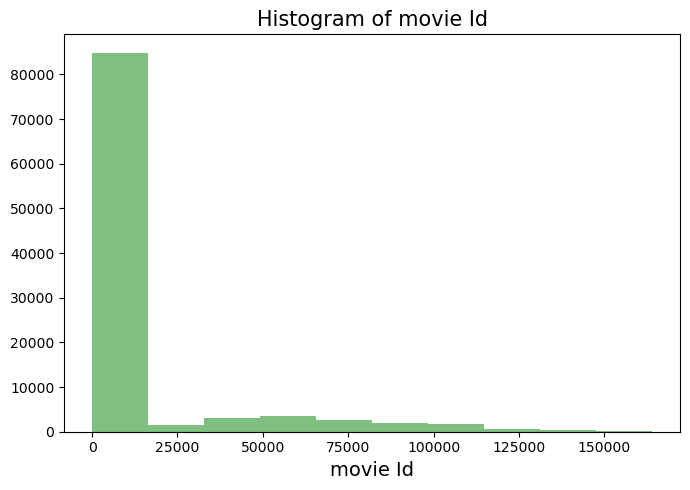

In [9]:
# Histogram of movieId
plt.figure(figsize=(7,5), tight_layout=True)
plt.hist(df['movieId'], color='Green', linewidth=0.3,alpha=0.5)
plt.xlabel('movie Id',fontsize=14)
plt.title('Histogram of movie Id', fontsize = 15)
plt.show()

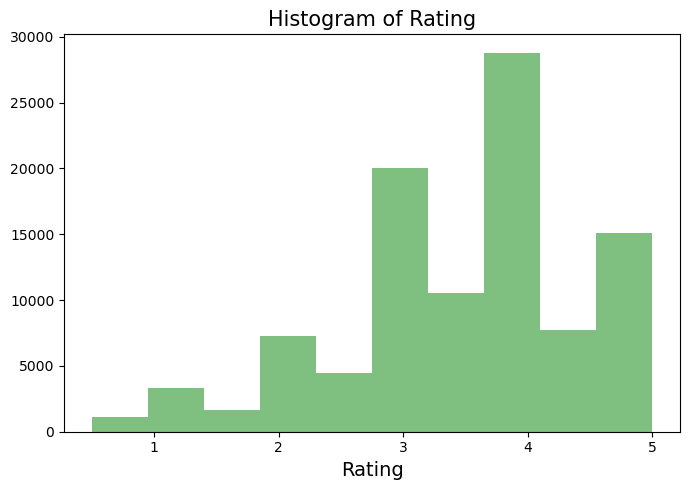

In [10]:
# Histogram of rating
plt.figure(figsize=(7,5), tight_layout=True)
plt.hist(df['rating'], color='Green', linewidth=0.3,alpha=0.5)
plt.xlabel('Rating',fontsize=14)
plt.title('Histogram of Rating', fontsize = 15)
plt.show()

## Recommendation Model - Colloborative Filtering

In [11]:
#Remove the timestamp variables
df2 = df.drop(['timestamp'], axis=1)
df2

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0
...,...,...,...
99999,671,6268,2.5
100000,671,6269,4.0
100001,671,6365,4.0
100002,671,6385,2.5


In [12]:
# import reader and set dataset
# A reader is still needed but only the rating_scale param is requiered.
#set the rating_scale
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df2[['userId', 'movieId', 'rating']], reader)
data

In [13]:
# set the seed
import random
import numpy as np

my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

### Matrix Factorisation Method

considering SVD, NMF, CoClustering and SlopeOne methods

In [14]:
benchmark = []
# Iterate over all algorithms
#for trainset, testset in kf.split(df): 
for algorithm in [SVD(), NMF(), CoClustering(), SlopeOne()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
    
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp._append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark.append(tmp)

In [16]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.895728,2.124370,0.349039
SlopeOne,0.927662,5.806456,10.597846
NMF,0.945043,5.046575,0.367081
CoClustering,0.963982,7.318391,0.292018


Best RMSE is given by the SVD model. Thus Conducting the Parameter Tuning for the SVD model. Further the time required to fit the model is also less compared to the others, meaning that SVD model is time efficient.

#### Applying parametor tuning method

#### Splitting the dataset into train and test sets

In [17]:
raw_ratings_data = data.raw_ratings
len(raw_ratings_data)

100004

In [18]:
# shuffle ratings 
random.shuffle(raw_ratings_data)
len(raw_ratings_data)

100004

In [19]:
# split the datset
# train = 80% of the data, test = 20% of the data
threshold_data = int(.8 * len(raw_ratings_data))
train_raw_ratings_data = raw_ratings_data[:threshold_data]
test_raw_ratings_data = raw_ratings_data[threshold_data:]

data.raw_ratings = train_raw_ratings_data  # data is now the train set

In [20]:
print('train set ',len(train_raw_ratings_data))
print('test set ',len(test_raw_ratings_data))
len(data.raw_ratings)

train set  80003
test set  20001


80003

#### Parametor Tunning 

In [21]:
#Parameter tunning for SVD algorithm
param_grid = {'n_factors': [15, 20, 25, 30], 'n_epochs': [2, 10, 15, 20], 'lr_all': [0.001, 0.003, 0.005, 0.008],
              'reg_all': [0.08, 0.1, 0.15]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
gs.fit(data)
algo = gs.best_estimator['rmse']
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8907695051982962
{'n_factors': 30, 'n_epochs': 20, 'lr_all': 0.008, 'reg_all': 0.08}


In [22]:
algo = SVD(n_factors = 30, n_epochs =20, lr_all = 0.008, reg_all = 0.08)

In [23]:
# retrain on the whole train set
trainset = data.build_full_trainset()
algo.fit(trainset)

In [24]:
# Compute biased accuracy on train set
predictions_train = algo.test(trainset.build_testset())
print('Biased accuracy on train set ,', end='   ')
accuracy.rmse(predictions_train)
svd_biased_accuaracy = accuracy.rmse(predictions_train)
svd_biased_accuaracy

Biased accuracy on train set ,   RMSE: 0.7916
RMSE: 0.7916


0.7916388557805362

In [25]:
# The dumps have been saved and we can now use them whenever we want.

dump.dump('./dump_svdtrain', predictions_train, algo)
predictions_train, algo = dump.load('./dump_svdtrain')

#uid :user id
#iid : item id (movie id)
#ruit : true rating
#est : estimated rating
df_svdtrain = pd.DataFrame(predictions_train, columns=['uid', 'iid', 'rui', 'est', 'details'])        

#error between true rating and estimated ratings
df_svdtrain['err'] = abs(df_svdtrain.est - df_svdtrain.rui)

In [26]:
df_svdtrain.head()

,uid,iid,rui,est,details,err
0,531,2683,3.0,2.617244,{'was_impossible': False},0.382756
1,531,1035,3.5,3.491714,{'was_impossible': False},0.008286
2,531,1997,0.5,2.889546,{'was_impossible': False},2.389546
3,531,1028,5.0,3.363076,{'was_impossible': False},1.636924
4,531,6942,4.5,3.399901,{'was_impossible': False},1.100099


In [27]:
best_predictions = df_svdtrain.sort_values(by='err')[:10]
worst_predictions = df_svdtrain.sort_values(by='err')[-10:]

In [28]:
# Let's take a look at the best predictions of the algorithm
best_predictions

,uid,iid,rui,est,details,err
63212,298,69481,5.0,5.0,{'was_impossible': False},0.0
28485,559,926,5.0,5.0,{'was_impossible': False},0.0
28445,559,318,5.0,5.0,{'was_impossible': False},0.0
63213,298,608,5.0,5.0,{'was_impossible': False},0.0
46732,656,858,5.0,5.0,{'was_impossible': False},0.0
63217,298,741,5.0,5.0,{'was_impossible': False},0.0
63223,298,2232,5.0,5.0,{'was_impossible': False},0.0
74614,622,318,5.0,5.0,{'was_impossible': False},0.0
31884,4,2064,5.0,5.0,{'was_impossible': False},0.0
76054,546,318,5.0,5.0,{'was_impossible': False},0.0


In [29]:
# Now, let's look at the prediction with the biggest error
worst_predictions

,uid,iid,rui,est,details,err
37449,501,111,0.5,4.054699,{'was_impossible': False},3.554699
70183,219,4993,0.5,4.058042,{'was_impossible': False},3.558042
14664,78,1089,1.0,4.587880,{'was_impossible': False},3.587880
47049,646,955,1.0,4.591771,{'was_impossible': False},3.591771
72941,479,5618,0.5,4.116877,{'was_impossible': False},3.616877
76062,546,1235,0.5,4.129580,{'was_impossible': False},3.629580
75018,304,527,0.5,4.171808,{'was_impossible': False},3.671808
52310,405,2858,0.5,4.192056,{'was_impossible': False},3.692056
30836,660,593,0.5,4.271056,{'was_impossible': False},3.771056
27643,287,924,0.5,4.716666,{'was_impossible': False},4.216666


#### Accuracy measures

In [30]:
# precision and recall
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [31]:
#biased accuracies
precisions, recalls = precision_recall_at_k(predictions_train, k=10, threshold=3)

# Precision and recall can then be averaged over all users
svd_biased_precision = sum(prec for prec in precisions.values()) / len(precisions)
svd_biased_recall = sum(rec for rec in recalls.values()) / len(recalls)


print('precision', svd_biased_precision)
print('recalls', svd_biased_recall)

precision 0.9685697726681319
recalls 0.25080202266971313


In [32]:
# Compute unbiased accuracy on test set
testset = data.construct_testset(test_raw_ratings_data)  # testset is now the test set
predictions_test = algo.test(testset)
print('Unbiased accuracy on test set,', end=' ')
accuracy.rmse(predictions_test)
svd_unbiased_accuracy = accuracy.rmse(predictions_test)
svd_unbiased_accuracy 

Unbiased accuracy on test set, RMSE: 0.8899
RMSE: 0.8899


0.8899108917072022

In [33]:
precisions, recalls = precision_recall_at_k(predictions_test, k=10, threshold=3.5)

# Precision and recall can then be averaged over all users
svd_unbiased_precision = sum(prec for prec in precisions.values()) / len(precisions)
svd_unbiased_recall = sum(rec for rec in recalls.values()) / len(recalls)


print('precision', svd_unbiased_precision)
print('recalls', svd_unbiased_recall)

precision 0.7281651267472168
recalls 0.5187628134648622


In [34]:
# The dumps have been saved and we can now use them whenever we want.

dump.dump('./dump_svdtest', predictions_test, algo)
predictions_test, algo = dump.load('./dump_svdtest')

df_svdtest = pd.DataFrame(predictions_test, columns=['uid', 'iid', 'rui', 'est', 'details'])        

df_svdtest['err'] = abs(df_svdtest.est - df_svdtest.rui)

In [35]:
df_svdtest.head()

,uid,iid,rui,est,details,err
0,380,53129,4.5,3.644090,{'was_impossible': False},0.855910
1,30,6419,5.0,3.879053,{'was_impossible': False},1.120947
2,433,48774,4.5,3.678797,{'was_impossible': False},0.821203
3,564,3491,4.0,3.657554,{'was_impossible': False},0.342446
4,73,58301,4.0,3.364760,{'was_impossible': False},0.635240


In [36]:
best_predictions_test = df_svdtest.sort_values(by='err')[:10]
worst_predictions_test = df_svdtest.sort_values(by='err')[-10:]

In [37]:
# Let's take a look at the best predictions of the algorithm
best_predictions_test

,uid,iid,rui,est,details,err
1702,298,3000,5.0,5.0,{'was_impossible': False},0.0
12225,242,899,5.0,5.0,{'was_impossible': False},0.0
10437,145,356,5.0,5.0,{'was_impossible': False},0.0
3625,242,1221,5.0,5.0,{'was_impossible': False},0.0
10136,298,98491,5.0,5.0,{'was_impossible': False},0.0
16534,298,318,5.0,5.0,{'was_impossible': False},0.0
6216,89,58559,5.0,5.0,{'was_impossible': False},0.0
4882,656,3363,5.0,5.0,{'was_impossible': False},0.0
19732,113,16,5.0,5.0,{'was_impossible': False},0.0
9634,298,31658,5.0,5.0,{'was_impossible': False},0.0


In [38]:
# Now, let's look at the prediction with the biggest error
worst_predictions_test

,uid,iid,rui,est,details,err
2521,609,3973,5.0,1.456260,{'was_impossible': False},3.543740
1668,607,1035,0.5,4.060158,{'was_impossible': False},3.560158
11359,261,235,0.5,4.064354,{'was_impossible': False},3.564354
385,430,8665,0.5,4.073541,{'was_impossible': False},3.573541
7114,568,356,1.0,4.573772,{'was_impossible': False},3.573772
3245,401,2005,1.0,4.629552,{'was_impossible': False},3.629552
14621,607,1208,0.5,4.154442,{'was_impossible': False},3.654442
13859,145,300,1.0,4.787191,{'was_impossible': False},3.787191
497,546,8622,0.5,4.508906,{'was_impossible': False},4.008906
12675,599,4973,0.5,4.515711,{'was_impossible': False},4.015711


## Item Based

In [39]:
# used same train and test set
print('train set ',len(train_raw_ratings_data))
print('test set ',len(test_raw_ratings_data))
len(data.raw_ratings)

train set  80003
test set  20001


80003

Considered similarity measures are msd, cosine and pearson

In [40]:
# Grid Search
print('grid search...')
sim_options = {
    "name": ["msd", "cosine", "pearson"],
    "user_based": [False],
}

param_grid = {"sim_options": sim_options}

gsi = GridSearchCV(KNNBasic, param_grid, measures=["rmse", "mae"], cv=5)
gsi.fit(data)

print(gsi.best_score["rmse"])
print(gsi.best_params["rmse"])

grid search...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing

for the item based, msd similarity measure gives the best accuracies

In [41]:
# get the best estimator
algo2 = gsi.best_estimator['rmse']

In [42]:
# retrain on the whole set A
trainset = data.build_full_trainset()
algo2.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [43]:
# Compute biased accuracy on train set
predictions2_train = algo2.test(trainset.build_testset())
print('Biased accuracy on train,', end='   ')
accuracy.rmse(predictions2_train)
item_biased_accuracy = accuracy.rmse(predictions2_train)
item_biased_accuracy

Biased accuracy on train,   RMSE: 0.4706
RMSE: 0.4706


0.47062980164896173

In [44]:
precisions, recalls = precision_recall_at_k(predictions2_train, k=10, threshold=3)

# Precision and recall can then be averaged over all users
item_biased_precision = sum(prec for prec in precisions.values()) / len(precisions)
item_biased_recall = sum(rec for rec in recalls.values()) / len(recalls)


print('precision', item_biased_precision)
print('recalls', item_biased_recall)

precision 0.9871833084947838
recalls 0.25382099819987464


In [45]:
# Compute unbiased accuracy on test set
# predict for the test set
testset = data.construct_testset(test_raw_ratings_data)  # testset is now the test
predictions2_test = algo2.test(testset)
print('Unbiased accuracy on test,', end=' ')
accuracy.rmse(predictions2_test)
item_unbiased_accuracy = accuracy.rmse(predictions2_test)
item_unbiased_accuracy

Unbiased accuracy on test, RMSE: 0.9348
RMSE: 0.9348


0.9347841914700026

In [46]:
precisions, recalls = precision_recall_at_k(predictions2_test, k=10, threshold=3)

# Precision and recall can then be averaged over all users
item_unbiased_precision = sum(prec for prec in precisions.values()) / len(precisions)
item_unbiased_recall = sum(rec for rec in recalls.values()) / len(recalls)


print('precision', item_unbiased_precision)
print('recalls', item_unbiased_recall)

precision 0.864668917318169
recalls 0.6031314230798884


## User Based

In [47]:
# used same train and test set
print('train set ',len(train_raw_ratings_data))
print('test set ',len(test_raw_ratings_data))
len(data.raw_ratings)

train set  80003
test set  20001


80003

considered the similarity measures are 'msd', 'cosine' and 'pearson'

In [48]:
# Grid Search
print('grid search...')
sim_options = {
    "name": ["msd", "cosine", "pearson"],
    "user_based": [True],
}

param_grid = {"sim_options": sim_options}

gsu = GridSearchCV(KNNBasic, param_grid, measures=["rmse", "mae"], cv=5)
gsu.fit(data)

print(gsu.best_score["rmse"])
print(gsu.best_params["rmse"])

grid search...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing

for user based, similarity measure 'msd' gives the best accuraices

In [49]:
# get the best estimator
algo3 = gsu.best_estimator['rmse']

In [50]:
# retrain on the whole set A
trainset = data.build_full_trainset()
algo3.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [51]:
# Compute biased accuracy on train set
predictions3_train = algo3.test(trainset.build_testset())
print('Biased accuracy on train,', end='   ')
accuracy.rmse(predictions3_train)
user_biased_accuracy = accuracy.rmse(predictions3_train)
user_biased_accuracy

Biased accuracy on train,   RMSE: 0.7159
RMSE: 0.7159


0.7159473937752777

In [52]:
precisions, recalls = precision_recall_at_k(predictions3_train, k=10, threshold=3)

# Precision and recall can then be averaged over all users
user_biased_precision = sum(prec for prec in precisions.values()) / len(precisions)
user_biased_recall = sum(rec for rec in recalls.values()) / len(recalls)


print('precision', user_biased_precision)
print('recalls', user_biased_recall)

precision 0.9903378042722306
recalls 0.27144497201211754


In [53]:
# Compute unbiased accuracy on test set
# predict for the test set
testset = data.construct_testset(test_raw_ratings_data)  # testset is now the test
predictions3_test = algo3.test(testset)
print('Unbiased accuracy on test,', end=' ')
accuracy.rmse(predictions3_test)
user_unbiased_accuracy = accuracy.rmse(predictions3_test)
user_unbiased_accuracy

Unbiased accuracy on test, RMSE: 0.9654
RMSE: 0.9654


0.9653700598949658

In [54]:
precisions, recalls = precision_recall_at_k(predictions3_test, k=10, threshold=3)

# Precision and recall can then be averaged over all users
user_unbiased_precision = sum(prec for prec in precisions.values()) / len(precisions)
user_unbiased_recall = sum(rec for rec in recalls.values()) / len(recalls)


print('precision', user_unbiased_precision)
print('recalls', user_unbiased_recall)

precision 0.902437218668561
recalls 0.6122181473703477


### Accuracy Comparison

In [55]:
# Creation of the dataframe.
dict = {'measure': ['rmse','precision','recall'],
                'svd_biased': [svd_biased_accuaracy, svd_biased_precision, svd_biased_recall],
                'svd_unbiased': [svd_unbiased_accuracy, svd_unbiased_precision, svd_unbiased_recall],
                'item_biased' :[item_biased_accuracy, item_biased_precision, item_biased_recall],
                'item_unbiased' : [item_unbiased_accuracy, item_unbiased_precision, item_unbiased_recall],
                'user_biased' :[user_biased_accuracy, user_biased_precision, user_biased_recall],
                'user_unbiased' : [user_unbiased_accuracy, user_unbiased_precision, user_unbiased_recall]}
measures = pd.DataFrame(dict)

In [56]:
measures

,measure,svd_biased,svd_unbiased,item_biased,item_unbiased,user_biased,user_unbiased
0,rmse,0.791639,0.889911,0.470630,0.934784,0.715947,0.965370
1,precision,0.968570,0.728165,0.987183,0.864669,0.990338,0.902437
2,recall,0.250802,0.518763,0.253821,0.603131,0.271445,0.612218


According to the results minimum unbiased RMSE id given by SVD method, the difference between svd and item based is : 0.044873, svd and user based is : 0.075459
Highest unbiased precision is given by user based method and second highest given by svd method, the difference between those two precision values are, 0.018677.
Highest unbiased recall is given by user based method, the difference between user based and recall values are, 0.017846.

Eventhough precision and recall is higher for user based method than SVD, the RMSE value is also high than SVD compared to other measures. Therefore SVD algorithm is considering as the best method for the analysis

### Recomendation for each user

In [57]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 2.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [58]:
#set the seed
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

In [59]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

In [60]:
# The columns must correspond to user id, item id and ratings (in that order).
data2 = Dataset.load_from_df(df2[['userId', 'movieId', 'rating']], reader)
data2

In [61]:
trainset = data2.build_full_trainset()

In [62]:
algo.fit(trainset)

In [63]:
# Then predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.4982


0.49818442717786343

In [64]:
len(testset)

5983282

In [65]:
top_n = get_top_n(predictions, n=10)

In [66]:
# Print the recommended items for each user
result = []
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])
    result.append((uid, [iid for (iid, _) in user_ratings]))

1 [905, 858, 926, 318, 1939, 3462, 7502, 8132, 1945, 899]
2 [318, 905, 969, 8132, 1217, 2318, 1945, 858, 1147, 3030]
3 [8132, 858, 969, 926, 905, 3462, 7502, 3035, 1945, 3030]
4 [318, 1221, 7502, 926, 1252, 3462, 905, 3035, 1939, 1217]
5 [969, 905, 318, 3462, 1948, 926, 8132, 1945, 1217, 3088]
6 [858, 318, 8132, 1221, 7502, 3462, 969, 905, 1217, 1939]
7 [858, 1221, 7502, 1939, 905, 969, 926, 1948, 1228, 3462]
8 [8132, 905, 7502, 3462, 1939, 1217, 926, 2318, 969, 1945]
9 [8132, 858, 7502, 3462, 905, 1945, 3035, 1939, 926, 1147]
10 [3469, 969, 905, 926, 3088, 8132, 3462, 858, 1945, 899]
11 [318, 905, 8132, 926, 3462, 858, 3030, 1945, 1147, 1254]
12 [7502, 969, 8132, 905, 7153, 926, 3469, 1945, 318, 2300]
13 [905, 8132, 858, 969, 1945, 926, 1939, 1228, 1221, 3462]
14 [905, 7502, 318, 969, 858, 926, 994, 3462, 1228, 8132]
15 [8132, 905, 1948, 969, 3035, 3469, 1939, 7502, 3037, 968]
16 [905, 926, 969, 8132, 3030, 7502, 1945, 1948, 3462, 2318]
17 [905, 1939, 8132, 3462, 7502, 1228, 926, 1217

In [67]:
# save results in a dataframe
recomends_df= pd.DataFrame(data=result, columns=["IUser Id", "recomendations"])
recomends_df

,IUser Id,recomendations
0,1,"[905, 858, 926, 318, 1939, 3462, 7502, 8132, 1..."
1,2,"[318, 905, 969, 8132, 1217, 2318, 1945, 858, 1..."
2,3,"[8132, 858, 969, 926, 905, 3462, 7502, 3035, 1..."
3,4,"[318, 1221, 7502, 926, 1252, 3462, 905, 3035, ..."
4,5,"[969, 905, 318, 3462, 1948, 926, 8132, 1945, 1..."
...,...,...
666,667,"[3462, 858, 905, 1948, 318, 8132, 926, 969, 12..."
667,668,"[858, 926, 3462, 1939, 1945, 1172, 905, 7502, ..."
668,669,"[858, 905, 318, 926, 7502, 1939, 1221, 3462, 1..."
669,670,"[1939, 926, 905, 969, 1945, 3035, 858, 913, 81..."


In [68]:
recomends_df[['rec_movie1','rec_movie2','rec_movie3','rec_movie4','rec_movie5','rec_movie6',
               'rec_movie7','rec_movie8','rec_movie9','rec_movie10']] = pd.DataFrame(recomends_df.recomendations.tolist(), index= recomends_df.index)
recomends_df.head(5)

,IUser Id,recomendations,rec_movie1,rec_movie2,rec_movie3,rec_movie4,rec_movie5,rec_movie6,rec_movie7,rec_movie8,rec_movie9,rec_movie10
0,1,"[905, 858, 926, 318, 1939, 3462, 7502, 8132, 1...",905,858,926,318,1939,3462,7502,8132,1945,899
1,2,"[318, 905, 969, 8132, 1217, 2318, 1945, 858, 1...",318,905,969,8132,1217,2318,1945,858,1147,3030
2,3,"[8132, 858, 969, 926, 905, 3462, 7502, 3035, 1...",8132,858,969,926,905,3462,7502,3035,1945,3030
3,4,"[318, 1221, 7502, 926, 1252, 3462, 905, 3035, ...",318,1221,7502,926,1252,3462,905,3035,1939,1217
4,5,"[969, 905, 318, 3462, 1948, 926, 8132, 1945, 1...",969,905,318,3462,1948,926,8132,1945,1217,3088


In [69]:
recomends_df.drop(["recomendations"], axis =1, inplace =True)
recomends_df.head(5)

,IUser Id,rec_movie1,rec_movie2,rec_movie3,rec_movie4,rec_movie5,rec_movie6,rec_movie7,rec_movie8,rec_movie9,rec_movie10
0,1,905,858,926,318,1939,3462,7502,8132,1945,899
1,2,318,905,969,8132,1217,2318,1945,858,1147,3030
2,3,8132,858,969,926,905,3462,7502,3035,1945,3030
3,4,318,1221,7502,926,1252,3462,905,3035,1939,1217
4,5,969,905,318,3462,1948,926,8132,1945,1217,3088


### Recommends movies to a particular user

In [70]:
all_pred = get_top_n(predictions)

In [72]:
n = 10
for uid, user_ratings in all_pred.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    all_pred[uid] = user_ratings[:n]

In [73]:
tmp = pd.DataFrame.from_dict(all_pred)
tmp_transpose = tmp.transpose()

In [74]:
#Function for getting recommended movies for a particular user
def get_predictions(user_id):
    results2 = tmp_transpose.loc[user_id]
    return results2

In [75]:
#Getting prediction for user who is holding the user id 20
user_id=20
results2 = get_predictions(user_id)
results2

0     (1147, 4.054368665849275)
1    (3035, 4.0346681744478206)
2      (969, 4.030937108296863)
3    (8132, 4.0126447330663915)
4    (1254, 3.9981584375961208)
5      (926, 3.986443277795611)
6     (3022, 3.985513127918612)
7    (5114, 3.9789477885104803)
8     (1948, 3.978541081547122)
9    (3462, 3.9736041218212894)
Name: 20, dtype: object

In [76]:
#extracting the movie ids
recommended_movie_ids=[]
for x in range(0, n):
    recommended_movie_ids.append(results2[x][0])

recommended_movie_ids

[1147, 3035, 969, 8132, 1254, 926, 3022, 5114, 1948, 3462]